In [1]:
import os
import time
import abc

import jax.tree_util
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from jax import vmap
import jax.numpy as jnp
import jax.random as random

import numpyro
from numpyro import handlers
from numpyro.distributions import constraints
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, SVI, Predictive, Trace_ELBO, autoguide

from typing import Any, Callable, Iterable, Optional

In [2]:
%matplotlib inline
matplotlib.use("nbAgg")  # noqa: E402

In [3]:
DEVICE = "cpu"
numpyro.set_platform(DEVICE)
# numpyro.set_host_device_count(NUM_CHAINS)
D_X = 3

In [4]:
class Data(abc.ABC):
    @property
    @abc.abstractmethod
    def train(self) -> tuple[jnp.ndarray, jnp.ndarray]:
        raise NotImplementedError()

    @property
    @abc.abstractmethod
    def test(self) -> tuple[jnp.ndarray, jnp.ndarray]:
        raise NotImplementedError()

    @abc.abstractmethod
    def true_predictive(self, X: jnp.ndarray) -> dist.Distribution:
        raise NotImplementedError()

In [5]:
# Define toy regression problem
# create artificial regression dataset
class ToyData1(Data):
    def __init__(self, D_X: int = 3, sigma_obs: float = 0.05, train_size: int = 50, test_size: int = 500):
        self.D_X = D_X
        self.sigma_obs = sigma_obs
        D_Y = 1  # create 1d outputs
        np.random.seed(0)
        X = jnp.linspace(-1, 1, train_size)
        X = jnp.power(X[:, np.newaxis], jnp.arange(D_X))
        W = 0.5 * np.random.randn(D_X)
        # y = w0 + w1*x + w2*x**2 + 1/2 (1/2+x)**2 * sin(4x)
        Y = jnp.dot(X, W) + 0.5 * jnp.power(0.5 + X[:, 1], 2.0) * jnp.sin(4.0 * X[:, 1])
        Y += sigma_obs * np.random.randn(train_size)
        Y = Y[:, np.newaxis]
        Y -= jnp.mean(Y)
        Y /= jnp.std(Y)

        assert X.shape == (train_size, D_X)
        assert Y.shape == (train_size, D_Y)

        X_test = jnp.linspace(-1.3, 1.3, test_size)
        X_test = jnp.power(X_test[:, np.newaxis], jnp.arange(D_X))

        self._X = X
        self._Y = Y
        self._X_test = X_test
        self._Y_test = None

    def train(self):
        return (self._X, self._Y)

    def test(self):
        return (self._X_test, self._Y_test)

    def true_predictive(self, X: jnp.ndarray) -> dist.Distribution:
        raise NotImplementedError()

In [6]:
data = ToyData1(D_X=D_X, train_size=100)

In [7]:
class BayesianNeuralNetwork:
    def __init__(self,
                 nonlin: Callable[[jnp.ndarray], jnp.ndarray],
                 D_X: int,
                 D_Y: int,
                 D_H: int,
                 L: int,
                 biases: bool):
        self._nonlin = nonlin
        self.D_X = D_X
        self.D_Y = D_Y
        self.D_H = D_H
        assert L >= 2
        self.L = L
        assert not biases
        self._biases = biases
        # Initialise priors to independent standard normals
        self._prior_w = dist.MultivariateNormal(jnp.zeros(self.get_weight_dim()), jnp.eye(self.get_weight_dim()))
        self._prior_prec_obs = dist.Gamma(3.0, 1.0)

    def get_weight_dim(self) -> int:
        assert not self._biases
        return self.D_X * self.D_H + (self.L - 2) * self.D_H * self.D_H + self.D_H * self.D_Y

    def _wi_from_flat(self, a: jnp.ndarray, depth: int) -> jnp.ndarray:
        assert a.shape[0] == self.get_weight_dim()
        assert 0 <= depth < self.L
        assert not self._biases
        if depth == 0:
            return a[:(self.D_X * self.D_H)].reshape((self.D_X, self.D_H))
        if depth == self.L-1:
            return a[-(self.D_H * self.D_Y):].reshape((self.D_H, self.D_Y))
        mid = a[(self.D_X * self.D_H):-(self.D_H * self.D_Y)]
        mid_mat_size = self.D_H * self.D_H
        return mid[(depth-1)*mid_mat_size:depth*mid_mat_size].reshape((self.D_H, self.D_H))

    #noinspection PyPep8Naming
    def __call__(self, X: jnp.ndarray, Y: Optional[jnp.ndarray] = None):
        N, D_X = X.shape
        assert D_X == self.D_X

        # sample weights from prior
        w = numpyro.sample("w", self._prior_w)

        pre_activ = jnp.matmul(X, self._wi_from_flat(w, depth=0))
        for depth in range(1, self.L):
            pre_activ = jnp.matmul(self._nonlin(pre_activ), self._wi_from_flat(w, depth))

        if Y is not None:
            assert pre_activ.shape == Y.shape

        # we put a prior on the observation noise
        prec_obs = numpyro.sample("prec_obs", self._prior_prec_obs)
        sigma_obs = numpyro.deterministic("sigma_obs", 1.0 / jnp.sqrt(prec_obs))

        # observe data
        numpyro.sample("Y", dist.Normal(pre_activ, jnp.full((N, self.D_Y), sigma_obs)), obs=Y)

    def set_prior(self, prior_w: dist.Distribution, prior_prec_obs: dist.Distribution):
        self._prior_w = prior_w
        self._prior_prec_obs = prior_prec_obs

In [8]:
bnn = BayesianNeuralNetwork(
    nonlin=jnp.tanh,
    D_X=D_X,
    D_Y=1,
    D_H=5,
    L=3,
    biases=False
)

In [9]:
class Experiment(abc.ABC):
    def __init__(self, bnn: BayesianNeuralNetwork, data: Data):
        self._bnn: BayesianNeuralNetwork = bnn
        self._data: Data = data
        # Initialise state
        self._predictions: Optional[jnp.ndarray] = None  # of shape (num_samples, X_test.shape[0])

    @abc.abstractmethod
    def train(self, rng_key_train: random.PRNGKey):
        pass

    @abc.abstractmethod
    def make_predictions(self, rng_key_predict: random.PRNGKey):
        pass

    def make_plots(self) -> plt.Figure:
        assert self._predictions is not None
        X, Y = self._data.train()
        X_test, _ = self._data.test()
        # compute mean prediction and confidence interval around median
        mean_predictions = jnp.mean(self._predictions, axis=0)
        percentiles = np.percentile(self._predictions, [5.0, 95.0], axis=0)
        # plotting
        fig, ax = plt.subplots(figsize=(6, 4))
        # plot training data
        ax.plot(X[:, 1], Y[:, 0], "kx")
        # plot predictions & quantiles
        ax.plot(X_test[:, 1], mean_predictions, color="blue")
        ax.fill_between(X_test[:, 1], *percentiles, color="lightblue")
        return fig

    def run(self, rng_key: random.PRNGKey):
        rng_key_train, rng_key_predict = random.split(rng_key)
        self.train(rng_key_train)
        self.make_predictions(rng_key_predict)
        fig = self.make_plots()
        return fig

In [10]:
class BasicHMCExperiment(Experiment):
    def __init__(self, bnn: BayesianNeuralNetwork, data: Data, num_samples: int = 2_000,
                 num_warmup: int = 1_000, num_chains: int = 1):
        super().__init__(bnn, data)
        self._num_samples = num_samples
        self._num_warmup = num_warmup
        self._num_chains = num_chains
        # Initialise state
        self._samples: Optional[dict] = None

    def train(self, rng_key_train: random.PRNGKey):
        start = time.time()
        X, Y = self._data.train()
        kernel = NUTS(self._bnn)
        mcmc = MCMC(
            kernel,
            num_warmup=self._num_warmup,
            num_samples=self._num_samples,
            num_chains=self._num_chains,
            progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
        )
        mcmc.run(rng_key_train, X, Y)
        mcmc.print_summary()
        print("\nMCMC elapsed time:", time.time() - start)
        self._samples = mcmc.get_samples()

    def make_predictions(self, rng_key_predict: random.PRNGKey):
        assert self._samples is not None
        X_test, _ = self._data.test()
        self._predictions = Predictive(self._bnn, self._samples)(rng_key_predict, X=X_test, Y=None)['Y'][..., 0]

sample: 100%|██████████| 300/300 [00:13<00:00, 23.01it/s, 1023 steps of size 3.35e-03. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  prec_obs     18.13      2.70     18.00     13.51     22.19    228.14      1.00
      w[0]      0.62      1.15      0.64     -1.38      2.15     20.88      1.02
      w[1]     -0.48      1.31     -0.76     -2.14      1.75     15.75      1.01
      w[2]     -0.05      1.24      0.03     -2.15      1.83     14.43      1.01
      w[3]      0.11      1.01      0.29     -1.53      1.81     59.53      1.00
      w[4]      0.11      0.74      0.20     -1.06      1.22     25.19      1.12
      w[5]     -0.61      0.97     -0.77     -1.89      1.16     26.71      1.13
      w[6]      0.14      1.07      0.28     -1.66      1.65     36.47      1.03
      w[7]     -0.19      0.99     -0.30     -1.61      1.33     22.32      1.04
      w[8]     -0.01      1.06      0.09     -1.63      1.52     44.55      1.05
      w[9]     -0.10      1.37     -0.22     -2.00      1.87     11.62      1.19
     w[10]     -0.43      1

<IPython.core.display.Javascript object>

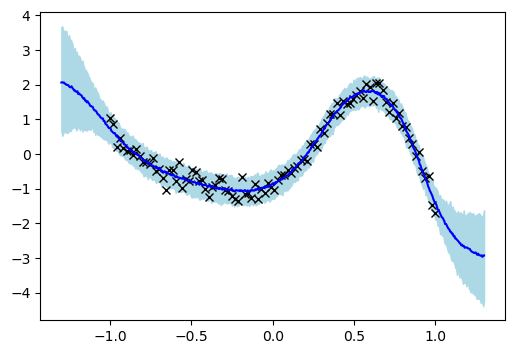

In [11]:
experiment = BasicHMCExperiment(
    bnn,
    data,
    num_samples = 200, num_warmup = 100,
)
experiment.run(random.PRNGKey(0))

In [12]:
class BasicVIExperiment(Experiment):
    def __init__(self, bnn: BayesianNeuralNetwork, data: Data, num_samples: int = 2_000,
                 max_iter: int = 5_000):
        super().__init__(bnn, data)
        self._num_samples = num_samples
        self._max_iter = max_iter
        # Initialise state
        self._params: Optional[dict] = None

    def _get_mean_field_guide(self) -> Callable[[jnp.ndarray, Optional[jnp.ndarray]], Any]:
        bnn_weight_dim = self._bnn.get_weight_dim()
        def guide(X, Y=None):
            w_loc = numpyro.param("w_loc", lambda rng_key: dist.Normal().sample(rng_key, (bnn_weight_dim,)))
            w_scale = numpyro.param("w_scale", jnp.full((bnn_weight_dim,), 0.1), constraint=constraints.positive)
            numpyro.sample("w", dist.Normal(w_loc, w_scale).to_event(1))
            prec_obs_loc = numpyro.param("prec_obs_loc", 1.0, constraint=constraints.positive)
            numpyro.sample("prec_obs", dist.Delta(prec_obs_loc))
        return guide

    def train(self, rng_key_train: random.PRNGKey):
        start = time.time()
        X, Y = self._data.train()
        guide = self._get_mean_field_guide()
        optimizer = numpyro.optim.Adam(0.005)
        svi = SVI(self._bnn, guide, optimizer, Trace_ELBO())
        svi_results = svi.run(rng_key_train, self._max_iter, X=X, Y=Y)
        params = svi_results.params
        print("\nSVI elapsed time:", time.time() - start)
        self._params = params

    def make_predictions(self, rng_key_predict: random.PRNGKey):
        assert self._params is not None
        X_test, _ = self._data.test()
        predictive = Predictive(model=self._bnn, guide=self._get_mean_field_guide(),
                                params=self._params, num_samples=self._num_samples)
        self._predictions = predictive(rng_key_predict, X=X_test, Y=None)['Y'][..., 0]

100%|██████████| 10000/10000 [00:14<00:00, 699.18it/s, init loss: 414.6161, avg. loss [9501-10000]: 117.6498]



SVI elapsed time: 17.255687952041626


<IPython.core.display.Javascript object>

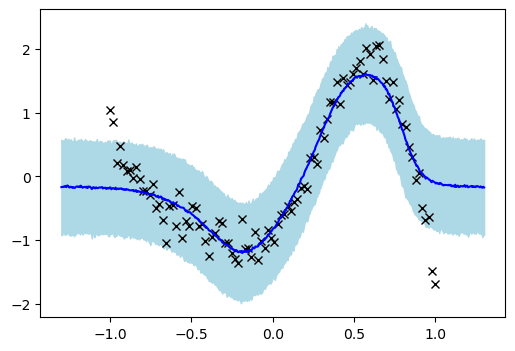

In [13]:
experiment = BasicVIExperiment(
    bnn,
    data,
    num_samples=2_000,
    max_iter=10_000,
)
experiment.run(random.PRNGKey(0))

In [14]:
# plt.close('all')